<h1 align='center'>O que é RFV?</h1>
<p>RFV é uma sigla para “Recência, Frequência e Valor Monetário”. Em resumo, trata-se de uma técnica que visa identificar/mensurar em uma base de dados quais foram os clientes que fizeram compras recentes, quais são os mais frequentes e quais deles entregam um ticket médio maior para a sua companhia.</p>
</br>
<p>Baseado nesses três dados, é possível chegar a uma lista de quais são os melhores clientes da sua carteira. Em teoria, o RFV indicará quais são os consumidores mais propensos a fechar negócio com você novamente, de forma que eles representam o grupo que mais deve receber atenção da sua parte.</p>

In [16]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation
import pandas as pd
import numpy as np
import time

# Creating model
from sklearn.cluster import KMeans
import math
import sys

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'BancoDeDados/BancoDeDados.csv'

data = pd.read_csv(path, sep=',')
data.head()

,amostra,id_cliente,id_unico_cliente,item_id,cep_cliente,cidade_cliente,estado_cliente,id_pedido,status_pedido,horario_pedido,...,pagamento_sequencial,pagamento_tipo,pagamento_prestacoes,pagamento_valor,review,categoria,categoria_ingles,cep_vendedor,cidade_vendedor,estado_vendedor
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,1,credit_card,2,146.87,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
1,1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,1,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
2,2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,2,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
3,3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,1,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,...,1,credit_card,7,140.61,3,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
4,4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,1,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,...,1,credit_card,10,137.58,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP


In [3]:
def plot_perc(st, dados):
    plt.figure(figsize=(20, 10))
    
    g = sns.countplot(x=st, data=dados, orient='h')
    g.set_ylabel('Contagem', fontsize=16)
    
    sizes = []
    
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x() + p.get_width()/1.6,
               height+200,
               '{:1.2f}%'.format(height/116581*100),
               ha= 'center', va='bottom', fontsize=12)
        
    g.set_ylim(0, max(sizes)*1.1)
    plt.tight_layout()

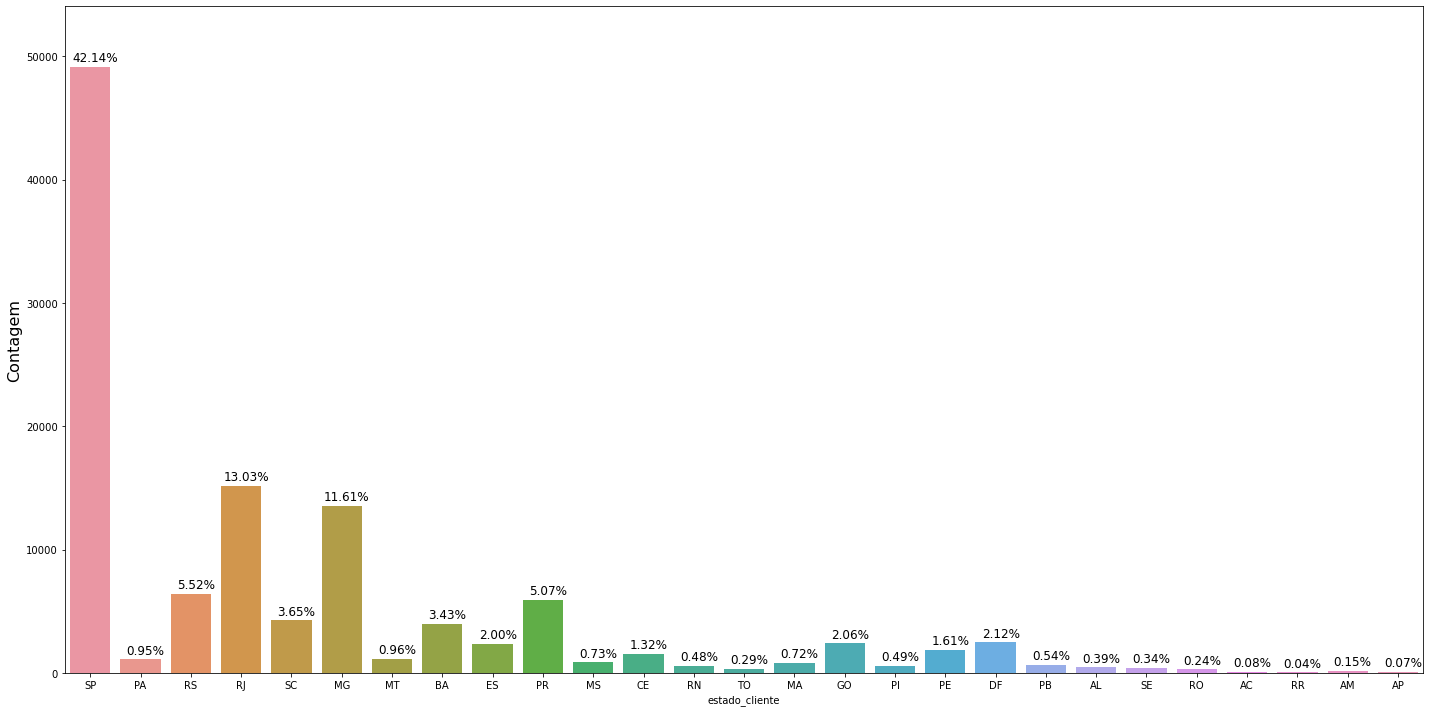

In [4]:
plot_perc('estado_cliente', data)

In [5]:
df_analise = data[['id_unico_cliente', 'id_cliente','item_id', 'preco']]
# Obtendo o valor da recencia do cliente
df_compra = data.groupby('id_unico_cliente').horario_pedido.max().reset_index()
df_compra.columns = ['id_unico_cliente', 'DataMaxCompra']
df_compra['DataMaxCompra'] = pd.to_datetime(df_compra['DataMaxCompra'])
df_compra['Recencia'] = (df_compra['DataMaxCompra'].max() - df_compra['DataMaxCompra']).dt.days

In [7]:
df_usuario = pd.merge(df_analise, df_compra[['id_unico_cliente', 'Recencia']], on='id_unico_cliente')
df_usuario

,id_unico_cliente,id_cliente,item_id,preco,Recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,1,124.99,474
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,1,112.99,298
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2,112.99,298
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,1,124.99,483
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,1,106.99,211
...,...,...,...,...,...
116576,c5da6424f1f5decedef8672a1a0103e1,ce2172509c4149d65212484eb761bc37,1,289.49,12
116577,8d80e477643ec569b24592ce3d9dfc4c,ee1cfdc92e449920e25d3ca4ab4da4f6,1,19.00,41
116578,8d80e477643ec569b24592ce3d9dfc4c,ee1cfdc92e449920e25d3ca4ab4da4f6,2,39.90,41
116579,8c3c961a52bb5a0ffbce1d4e6d25cd67,ab0cf72dfe0538a63a57d6905ccb7b57,1,57.90,36


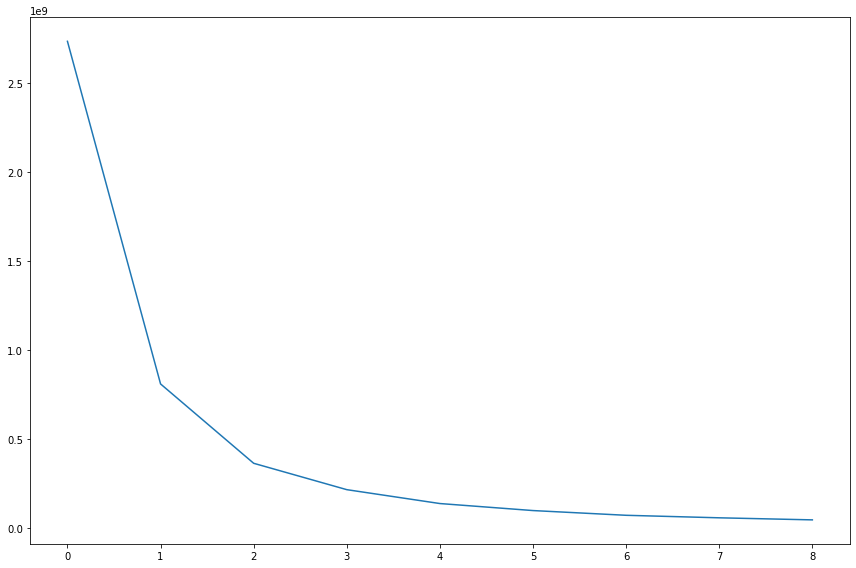

In [17]:
def calcular_wcss(data):
    wcss = []
    # encontrando o valor da innertia entre 10 clusters
    for k in range(1, 10):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(data)
        data['Clusters'] = kmeans.labels_
        wcss.append(kmeans.inertia_)
        
    # Plotando o grafico da innertia
    plt.figure(figsize=(12,8))
    plt.plot(wcss) 
    plt.tight_layout()
    return wcss

recencia = df_usuario[['Recencia']]
quadrados = calcular_wcss(recencia)

<p>Me parece que o numero otimo de clusters e 3-4, mas para termos certeza vamos aplicar uma formula para ter certaza do numero otimo de clusters!</p>

In [18]:
# H0: 3-4
def numero_otimo_clusters(wcss):
    x1, y1 = 2,wcss[0]
    x2, y2 = 20,wcss[len(wcss)-1]
    
    distancia = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerador = abs((y2 - y1)*x0-(x2 - x1)*y0 + x2*y1-y2*x1)
        denominador = math.sqrt((y2 - y1)**2 +(x2- x1)**2)
        distancia.append(numerador/denominador)
    return distancia.index(max(distancia)) + 2

n = numero_otimo_clusters(quadrados)
n

4

In [19]:
kmeans = KMeans(n_clusters=4)
df_usuario['RecenciaCluster'] = kmeans.fit_predict(recencia)
df_usuario.head()

,id_unico_cliente,id_cliente,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,1,124.99,474,3
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,1,112.99,298,1
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2,112.99,298,1
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,1,124.99,483,3
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,1,106.99,211,2


In [20]:
agrupado_por_cluster = df_usuario.groupby('RecenciaCluster')['Recencia'].mean().reset_index().sort_values(by='Recencia', ascending=True)
agrupado_por_cluster

,RecenciaCluster,Recencia
0,0,66.790878
2,2,187.911204
1,1,320.233294
3,3,490.622269


In [40]:
def ordena_clusters(cluster_nome, target_nome, df):
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome, ascending=True).reset_index(drop=True)
    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df , agrupado_por_cluster_ordenado[[cluster_nome, 'index']], on=cluster_nome)
    removendo_dados = juntando_cluster.drop([cluster_nome], axis=1)
    df_final = removendo_dados.rename(columns={'index':cluster_nome})
    return df_final

In [28]:
df_usuario = ordena_clusters('RecenciaCluster','Recencia', df_usuario)
df_usuario.head()

,id_unico_cliente,id_cliente,item_id,preco,Recencia,Frequencia_x,Frequencia_y,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,1,124.99,474,1,1,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,1,124.99,483,1,1,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,1,126.99,528,1,1,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,1,124.99,474,1,1,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,1,126.99,533,1,1,0


In [56]:
df_usuario.groupby('RecenciaCluster')['Recencia'].describe()
# Atribuindo uma nota maior a clientes que recentemente fizeram compras

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,20324.0,490.622269,59.293154,406.0,444.0,481.0,533.0,728.0
1,30828.0,320.233294,43.971639,255.0,281.0,314.0,357.0,405.0
2,33639.0,187.911204,35.134736,128.0,158.0,187.0,218.0,254.0
3,31790.0,66.790878,36.009443,0.0,33.0,67.0,100.0,127.0


In [31]:
df_frequencia = data.groupby('id_unico_cliente').pedido_aprovado.count().reset_index()
df_frequencia.columns = ['id_unico_cliente', 'Frequencia']
df_usuario = pd.merge(df_usuario, df_frequencia, on='id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,item_id,preco,Recencia,RecenciaCluster,Frequencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,1,124.99,474,0,1
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,1,124.99,483,0,1
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,1,126.99,528,0,1
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,1,124.99,474,0,1
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,1,126.99,533,0,1


In [36]:
freq = df_usuario[['Frequencia']]
kmeans = KMeans(n_clusters=4)
df_usuario['FrequenciaCluster'] = kmeans.fit_predict(freq)
df_usuario.head()

,id_unico_cliente,id_cliente,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,1,124.99,474,0,1,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,1,124.99,483,0,1,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,1,126.99,528,0,1,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,1,124.99,474,0,1,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,1,126.99,533,0,1,0


In [41]:
# Ordenando os clusters
df_usuario = ordena_clusters('FrequenciaCluster', 'Frequencia', df_usuario)
df_usuario.head()

,id_unico_cliente,id_cliente,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,1,124.99,474,0,1,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,1,124.99,483,0,1,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,1,126.99,528,0,1,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,1,124.99,474,0,1,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,1,126.99,533,0,1,0


In [43]:
# Checkando o resultado
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,9317.0,5.744875,2.312449,4.0,4.0,5.0,6.0,14.0
2,619.0,22.844911,6.267127,15.0,19.0,22.0,24.0,38.0
3,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


<p>Nossa base de dados esta quase completa, ja temos o valor de recencia e de frequencias defidos, agora falta apenas cirar e ordenar os valores monetarios!</p>

In [52]:
# Destacando o valor da receita do df
df_receita = data.groupby('id_unico_cliente').pagamento_valor.sum().reset_index()
df_receita.columns = ['id_unico_cliente', 'Receita']
# Adicionando a coluna receita ao df_usuario
df_usuario = pd.merge(df_usuario, df_receita, on='id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,1,129.90,115,3,1,0,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,1,18.90,118,3,1,0,27.19
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,1,69.00,541,0,1,0,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,1,25.99,325,1,1,0,43.62
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,1,180.00,292,1,1,0,196.89


In [55]:
df_pagamento = df_usuario[['Receita']]
kmeans = KMeans(n_clusters=4)
df_usuario['ReceitaCluster'] = kmeans.fit_predict(df_pagamento)
df_usuario.head()

,id_unico_cliente,id_cliente,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,1,129.90,115,3,1,0,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,1,18.90,118,3,1,0,27.19,0
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,1,69.00,541,0,1,0,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,1,25.99,325,1,1,0,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,1,180.00,292,1,1,0,196.89,0


In [58]:
df_usuario = ordena_clusters('ReceitaCluster', 'Receita', df_usuario)

In [61]:
df_usuario.groupby(['ReceitaCluster']).Receita.describe()

,count,mean,std,min,25%,50%,75%,max
ReceitaCluster,,,,,,,,
0,114763.0,258.095126,364.892800,9.59,69.90,132.57,269.10,2950.16
1,1619.0,5650.053385,2881.999747,2951.83,3557.12,4491.44,6914.63,16313.60
2,191.0,27358.656911,10032.832924,17069.76,19167.26,25051.89,30186.00,45256.00
3,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.64,109312.64


<p>Limpando o DataFrame para uma analise posterior dos nossos clientes!</p>

In [62]:
df_usuario.to_csv('df_final_sujo.csv', index=False, encoding='UTF-8')